# 02 Text Analisys and Modeling

I've decided to take text analysis to a new notebook to separate it from the rest of the project. This way, I can focus on the text analysis in a clean environment.

## Imports

In [1]:
import gensim
import nltk
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
import pyLDAvis

from catboost import CatBoostClassifier, cv, Pool
from gensim import corpora
from gensim.models import LdaModel
from nltk.corpus import stopwords
from nltk.stem import  WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.metrics import classification_report, precision_recall_curve, auc
from sklearn.model_selection import train_test_split

pio.templates.default = "plotly_dark"
pio.renderers.default = "png"

nltk.download("punkt")
nltk.download("stopwords")
nltk.download("wordnet")
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\kinte\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kinte\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\kinte\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\kinte\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt_tab.zip.


True

## Load data

In [2]:
associate_df = pd.read_parquet("../data/associate_df.parquet")
associate_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1034 entries, 99951605 to 81484854
Data columns (total 13 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   age                                     1034 non-null   int64  
 1   region                                  1034 non-null   object 
 2   risk                                    1034 non-null   int64  
 3   days_survived                           1034 non-null   int64  
 4   churn                                   1034 non-null   int64  
 5   is_male                                 1034 non-null   int64  
 6   total_trx                               1034 non-null   int64  
 7   total_value                             1034 non-null   int64  
 8   avg_trx_value                           1034 non-null   float64
 9   total_cnp                               1034 non-null   int64  
 10  days_trx                                1034 non-null 

From the beginning we can see that not every associate requests support.

In [3]:
sac_df = pd.read_csv(
    "../data/atendimento.csv",
    sep=";",
    parse_dates=["data"],
    date_format="%d/%m/%Y",
    dtype={"id_associado": str, "id_atendimento": str},
)
sac_df = sac_df.sort_values("data")

sac_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 366 entries, 323 to 20
Data columns (total 4 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   id_atendimento           366 non-null    object        
 1   id_associado             366 non-null    object        
 2   data                     366 non-null    datetime64[ns]
 3   transcricao_atendimento  366 non-null    object        
dtypes: datetime64[ns](1), object(3)
memory usage: 14.3+ KB


From the associates that have contacted support, some have 2 or even 3 conversations. This could define how I tackle this case.

In [4]:
sac_df.loc[
    sac_df.duplicated(subset=["id_associado"], keep=False)
].id_associado.value_counts()

id_associado
81485208    3
99769534    3
99952599    3
99768714    3
81485415    3
99950715    3
81485148    2
81482133    2
81484652    2
99952648    2
99951624    2
99952670    2
99769716    2
99765774    2
81485074    2
81482721    2
81485200    2
99952780    2
99952782    2
99769831    2
99951316    2
81485107    2
81483358    2
99952443    2
99951328    2
81485238    2
81485129    2
81485307    2
99769428    2
99766474    2
99768902    2
81484297    2
81485349    2
99952804    2
99769676    2
99952585    2
81483773    2
99951365    2
99767906    2
99951336    2
81485257    2
99768546    2
99952795    2
99952383    2
99952020    2
81484429    2
81485334    2
81485359    2
99765917    2
99769900    2
99951444    2
99769092    2
99952634    2
99950977    2
81485288    2
Name: count, dtype: int64

## My Proposed Solution

Since there are multiple conversations for a single associate I could go through in two ways:

I. Left Join the conversations on the associate_df and embrace the duplicity: it will be simpler to deal with. A TF-iDF would do the trick here, but there would rise the problem of changing the overall distribution of the other variables when duplicating information in an already small dataset.

II. Topic Modeling as categorial variables: this is a bit harder, but may yield better results. If I apply topic modeling to the conversations I will be able to create categorical columns indicating how many conversations of which topic an associate had. The disadvantage here is the same of a PCA. The information would be heavily encoded and explicability methods would be difficult to apply.

I will follow with the second which, in my opinion, would do better in production environment to monitor the risk of churn of the associates, being good to oversee the database on a daily basis.

## Text Data Analisys

Now, let's begin extracting some insights from the textual data, while also applying preprocessing steps.

In [5]:
sac_df["churn"] = (
    sac_df["id_associado"].isin(associate_df.query("churn == 1").index).astype(int)
)

In [6]:
sac_df["transcricao_atendimento"].sample().values[0]

'Atendente: Olá! Por favor, diga como posso ajudar. Associado: Gostaria de solicitar um cartão de crédito com benefícios de educação. Atendente: Certo, precisamos de algumas informações sobre você, como nome completo, data de nascimento e CPF. Associado: Você não consegue ver no sistema? Não vou passar nenhuma informação. Atendente: Infelizmente não. Associado: Frustrante. Atendente: Agradecemos, um ótimo dia!'

In my preprocessing steps I included the removal of customer support messages. I think it is of more benefit to know what is the reason that brought the customer to look for support.

In [7]:
# Cleaning the text


def clean_text(text):
    text = word_tokenize(text, language="portuguese")
    text = [
        word if word not in ["Atendente", "Associado"] else f"\n{word}" for word in text
    ]
    text = " ".join(text)
    text = text.split("\n")
    text = [sentence for sentence in text if sentence.startswith("Associado")]
    text = " ".join(text)
    text = text.lower()
    text = word_tokenize(text, language="portuguese")
    text = [word for word in text if word.isalpha()]
    text = [
        word
        for word in text
        if word not in stopwords.words("portuguese") and len(word) > 2
    ]
    text = [word for word in text if word not in ["associado", "atendente"]]
    text = [WordNetLemmatizer().lemmatize(word) for word in text]
    return " ".join(text)


sac_df["chat_clean"] = sac_df["transcricao_atendimento"].apply(clean_text)
sac_df.head()

,id_atendimento,id_associado,data,transcricao_atendimento,churn,chat_clean
323,70256,81485148,2023-06-04,Atendente: Como posso ajudar? Associado: Quero...,1,quero saber sobre vantagens cartão crédito con...
362,70873,99952294,2023-06-04,"Atendente: Boa noite, no que posso ajudar? Ass...",0,cartão crédito recusado loja artigos produtos ...
125,48747,99951897,2023-06-04,Atendente: Obrigado por aguardar! Farei o seu ...,0,gostaria saber sobre regras uso cartão crédito...
157,49165,99767039,2023-06-05,"Atendente: Boa noite, no que posso ajudar? Ass...",0,quero fechar conta cartão crédito alguém demora
319,70153,99767103,2023-06-06,Atendente: Como posso ajudar? Associado: Gosta...,0,gostaria saber sobre regras uso cartão crédito...


In [8]:
sac_df.sample().values[0]

array(['60589', '99768209', Timestamp('2023-12-17 00:00:00'),
       'Atendente: Boa tarde, no que posso ajudar? Associado: Gostaria de saber sobre as regras de uso do meu cartão de crédito em lojas de artigos de alimentos online. Atendente: Claro, podemos fornecer informações sobre as regras de uso do seu cartão em lojas de artigos de alimentos online, como segurança e outras, preciso apenas de confirmação de identidade. Associado: Claro, vou mandar por email. Atendente: Recebi, irei prosseguir por email também. Associado: Agradeço. Atendente: Precisarei encerrar o chamado devido a falta de resposta.',
       0,
       'gostaria saber sobre regras uso cartão crédito lojas artigos alimentos online claro vou mandar email agradeço'],
      dtype=object)

What have I learned from looking through some samples: customers are complaining frequently about reply delays and limited support from the operators.

On the word cloud below we can spot some notable expressions/words that corroborate this: "demora", "frustrante", "roubado". Some are expressions regarding about simple rules of use of the credit card, general questions. It looks like the associates are looking for help either when they really need it or when a question that is not clear elsewhere comes up. And when they do ask for help, they, sometimes, do not find it.

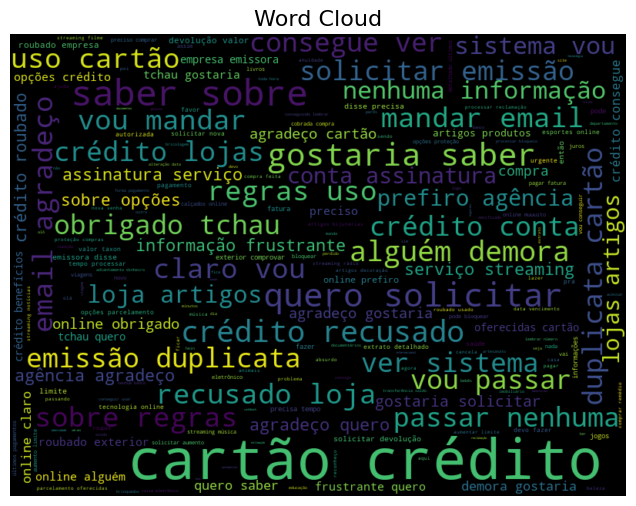

In [10]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

wordcloud = WordCloud(width=800, height=600).generate(
    sac_df["chat_clean"].str.cat(sep=" ")
)

plt.figure(figsize=(8, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud", fontsize=16)
plt.show()

When separating the wordclouds I confess I can't see much of a difference in subjects. Maybe churning customers are asking more for simple information than non churning customers.

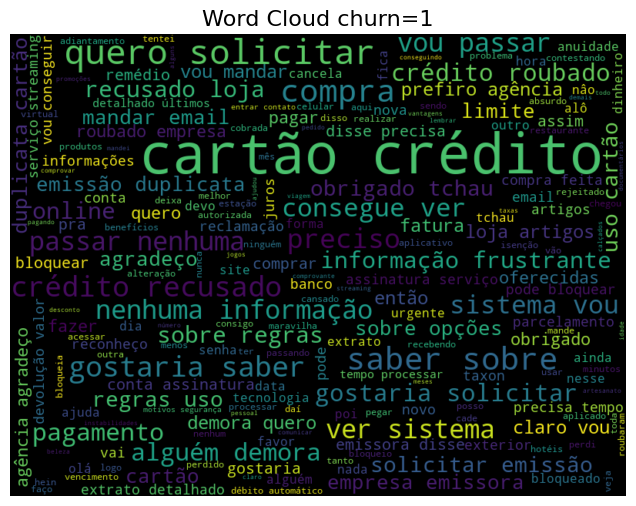

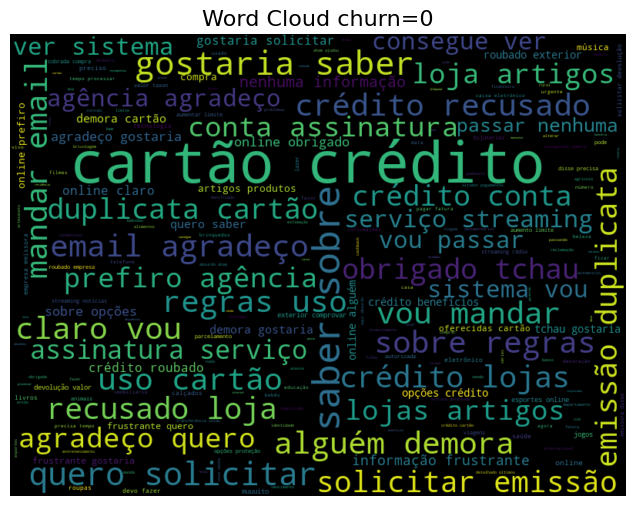

In [11]:
for c in sac_df.churn.unique():
    wordcloud = WordCloud(width=800, height=600).generate(
        sac_df.loc[sac_df.churn == c]["chat_clean"].str.cat(sep=" ")
    )

    plt.figure(figsize=(8, 6))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Word Cloud churn={c}", fontsize=16)
    plt.show()

Looking at the top k terms in the corpus it looks like churning customers had more bad experiences regarding stolen credit cards 

In [12]:
from collections import Counter


def print_top_k_terms(text_series, k=10):
    """
    This function counts the frequency of terms in a pandas.Series containing text data and prints the top k most frequent ones.

    Args:
        text_series: A pandas.Series containing textual data (e.g., conversation transcripts).
        k: The number of top terms to print (default: 10).
    """
    processed_text = text_series.str.lower()
    processed_text = (
        processed_text.str.split()
    ) 

    all_words = processed_text.sum()

    term_counts = Counter(all_words)
    total_words = len(all_words)

    print("Top", k, "Most Frequent Terms:")
    most_frequent_terms = sorted(
        term_counts.items(), key=lambda item: item[1], reverse=True
    )[:k]
    for term, count in most_frequent_terms:
        ratio = count / total_words
        print(f"{term}: {count} ({ratio:.4f}%)")

print_top_k_terms(sac_df["chat_clean"], 20)

Top 20 Most Frequent Terms:
cartão: 373 (0.0850%)
crédito: 363 (0.0827%)
quero: 117 (0.0267%)
gostaria: 115 (0.0262%)
solicitar: 114 (0.0260%)
vou: 112 (0.0255%)
agradeço: 105 (0.0239%)
online: 101 (0.0230%)
saber: 98 (0.0223%)
sobre: 98 (0.0223%)
artigos: 85 (0.0194%)
obrigado: 72 (0.0164%)
recusado: 66 (0.0150%)
email: 63 (0.0144%)
alguém: 63 (0.0144%)
demora: 61 (0.0139%)
mandar: 58 (0.0132%)
claro: 57 (0.0130%)
regras: 56 (0.0128%)
loja: 55 (0.0125%)


In [13]:
print_top_k_terms(sac_df.query("churn == 1")["chat_clean"], 20)

Top 20 Most Frequent Terms:
cartão: 126 (0.0887%)
crédito: 103 (0.0725%)
quero: 39 (0.0274%)
solicitar: 37 (0.0260%)
gostaria: 33 (0.0232%)
vou: 27 (0.0190%)
saber: 23 (0.0162%)
sobre: 23 (0.0162%)
ver: 18 (0.0127%)
compra: 18 (0.0127%)
recusado: 17 (0.0120%)
passar: 16 (0.0113%)
roubado: 15 (0.0106%)
obrigado: 15 (0.0106%)
alguém: 15 (0.0106%)
preciso: 15 (0.0106%)
sistema: 14 (0.0099%)
nenhuma: 14 (0.0099%)
informação: 14 (0.0099%)
agradeço: 14 (0.0099%)


In [14]:
print_top_k_terms(sac_df.query("churn == 0")["chat_clean"], 20)

Top 20 Most Frequent Terms:
crédito: 260 (0.0876%)
cartão: 247 (0.0832%)
online: 91 (0.0307%)
agradeço: 91 (0.0307%)
vou: 85 (0.0286%)
gostaria: 82 (0.0276%)
quero: 78 (0.0263%)
solicitar: 77 (0.0260%)
saber: 75 (0.0253%)
sobre: 75 (0.0253%)
artigos: 74 (0.0249%)
obrigado: 57 (0.0192%)
email: 51 (0.0172%)
recusado: 49 (0.0165%)
claro: 49 (0.0165%)
mandar: 48 (0.0162%)
alguém: 48 (0.0162%)
demora: 47 (0.0158%)
regras: 46 (0.0155%)
uso: 45 (0.0152%)


## Topic Modeling

Topic modeling will help us compress the transcript information for the model while also allowing us to better understand our data.

In [15]:
data_df = associate_df.copy()

X = data_df.drop(columns=["churn"])
y = data_df["churn"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [16]:
train_corpus = [
    word_tokenize(text)
    for text in sac_df.loc[sac_df.id_associado.isin(X_train.index)]["chat_clean"]
]
test_corpus = [
    word_tokenize(text)
    for text in sac_df.loc[sac_df.id_associado.isin(X_test.index)]["chat_clean"]
]

dictionary = corpora.Dictionary(train_corpus)
train_bow = [dictionary.doc2bow(text) for text in train_corpus]
test_bow = [dictionary.doc2bow(text) for text in test_corpus]

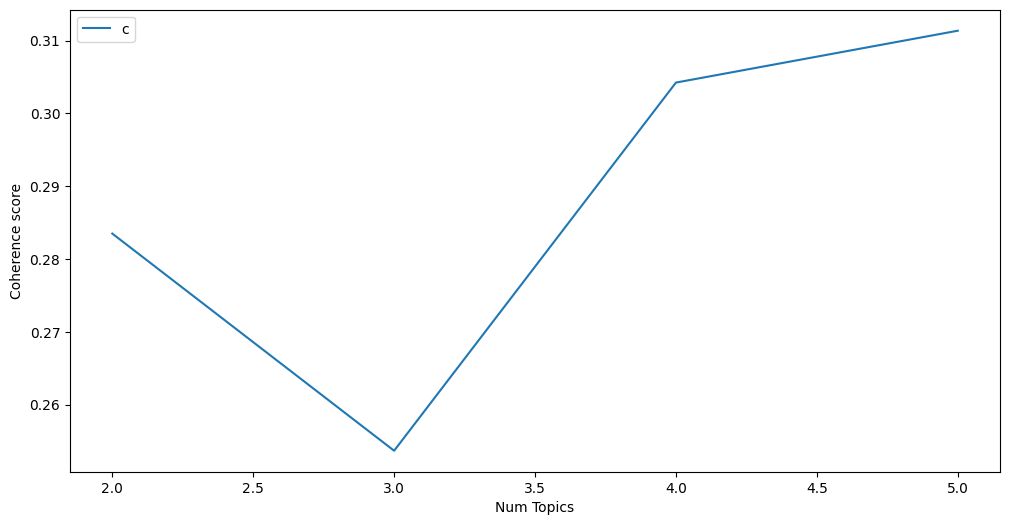

In [17]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = LdaModel(
            corpus=corpus, id2word=dictionary, num_topics=num_topics, random_state=42
        )
        model_list.append(model)
        coherencemodel = gensim.models.CoherenceModel(
            model=model, texts=texts, dictionary=dictionary, coherence="c_v"
        )
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values


model_list, coherence_values = compute_coherence_values(
    dictionary=dictionary,
    corpus=train_bow,
    texts=train_corpus,
    start=2,
    limit=6,
    step=1,
)

fig = plt.figure(figsize=(12, 6))
x = list(range(2, 6, 1))
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc="best")
plt.show()

Although the coherence score is not the best, it will suffice.

In [18]:
coherence_df = pd.DataFrame(
    {"num_topics": list(range(2, 6, 1)), "coherence": coherence_values}
)
coherence_df

,num_topics,coherence
0,2,0.283479
1,3,0.253655
2,4,0.304221
3,5,0.311344


Below we can see some interesting highlights in the topics. 

- Hovering above the token "demora" gives us a good idea of what the topic 1 contains. It isn't the subject of the conversation, but represents a common complaint among the associates. 

- Refusal complaints are also common among the associates, being more evenly distributed among the topics, but having a higher frequency on topic 3.

- Frustration looks like has been distributed over the topics, but it also has a considerable frequency.

In [19]:
best_model_idx = coherence_df["coherence"].idxmax()
best_num_topics = coherence_df.loc[best_model_idx, "num_topics"]
best_model = model_list[best_model_idx]

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(best_model, train_bow, dictionary)
vis

AttributeError: module 'pyLDAvis' has no attribute 'gensim'

Overall, the topics are well defined and reasonably spaced. However, it is valid to note that this could not be the best approach. Maybe if I had a human labeled contact reason this could be way more precise.

Below, we see the poential that the modeled topics have to differentiate the data, when they are present.

c:\Users\kinte\miniconda3\envs\eleven\Lib\site-packages\kaleido\scopes\base.py:188: DeprecationWarning:

setDaemon() is deprecated, set the daemon attribute instead



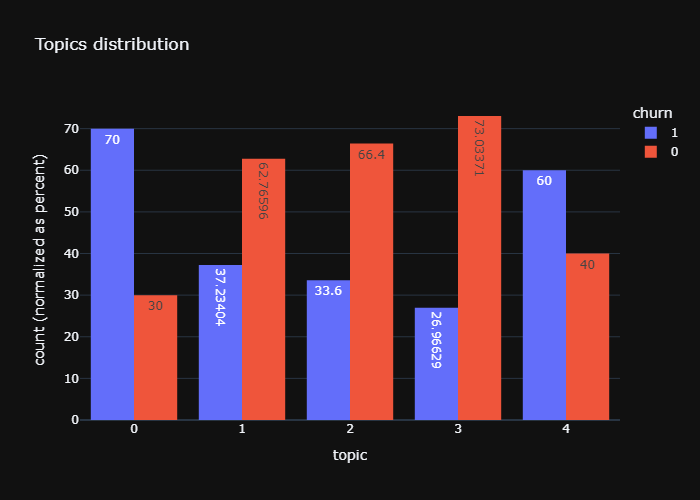

In [20]:
train_topics = best_model.get_document_topics(train_bow)
test_topics = best_model.get_document_topics(test_bow)

sac_df.loc[sac_df.id_associado.isin(X_train.index), "topic"] = [
    max(topics, key=lambda x: x[1])[0] for topics in train_topics
]
sac_df.loc[sac_df.id_associado.isin(X_test.index), "topic"] = [
    max(topics, key=lambda x: x[1])[0] for topics in test_topics
]

px.histogram(
    sac_df,
    x="topic",
    color="churn",
    barmode="group",
    title="Topics distribution",
    text_auto=True,
    barnorm="percent",
)

Let us now apply the topic modeling to the dataset and see how it performs. I chose to transform each topic into a count of how many conversations of that topic an associate had. This way, the model will be able to better monitor the risk of churn of the associates.

In [21]:
topic_df = (
    sac_df.groupby("id_associado")["topic"]
    .value_counts()
    .unstack()
    .fillna(0)
    .rename(columns={i: f"topic_{i}" for i in range(sac_df.topic.nunique())})
)
topic_df

topic,topic_0,topic_1,topic_2,topic_3,topic_4
id_associado,,,,,
81482133,0.0,2.0,0.0,0.0,0.0
81482170,0.0,1.0,0.0,0.0,0.0
81482193,0.0,0.0,1.0,0.0,0.0
81482251,0.0,1.0,0.0,0.0,0.0
81482373,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...
99952795,0.0,1.0,0.0,1.0,0.0
99952800,0.0,0.0,1.0,0.0,0.0
99952801,0.0,0.0,1.0,0.0,0.0


In [22]:
X_train_topics = (
    X_train.join(topic_df, how="left", on="id_associado")
    .fillna(0)
)
X_test_topics = (
    X_test.join(topic_df, how="left", on="id_associado")
    .fillna(0)
)
X_train_topics.info()
X_test_topics.info()

<class 'pandas.core.frame.DataFrame'>
Index: 827 entries, 99951345 to 99769287
Data columns (total 17 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   age                                     827 non-null    int64  
 1   region                                  827 non-null    object 
 2   risk                                    827 non-null    int64  
 3   days_survived                           827 non-null    int64  
 4   is_male                                 827 non-null    int64  
 5   total_trx                               827 non-null    int64  
 6   total_value                             827 non-null    int64  
 7   avg_trx_value                           827 non-null    float64
 8   total_cnp                               827 non-null    int64  
 9   days_trx                                827 non-null    int64  
 10  trx_per_day                             827 non-null   

## Training the Model

Catboost models are my go-to for tabular data. They can handle categorical data well and are easy to work with. I will use the model to predict the churn of the associates. With our data ready, let's train the model.

In [23]:
categorial_features = [
    "is_male",
    "region",
]

model = CatBoostClassifier(
    iterations=300,
    learning_rate=0.01,
    depth=6,
    loss_function="CrossEntropy",
    cat_features=categorial_features,
    verbose=False,
    eval_metric="PRAUC",
    use_best_model=False,
)

model.fit(
    X_train_topics,
    y_train,
    eval_set=(X_test_topics, y_test),
    plot=True,
)

y_pred = model.predict(X_test_topics)

print(classification_report(y_test, y_pred))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       185
           1       0.95      0.86      0.90        22

    accuracy                           0.98       207
   macro avg       0.97      0.93      0.95       207
weighted avg       0.98      0.98      0.98       207



The model is performing well, with a 0.98 PRAUC score. However, I have to take these result with a heavy grain of salt. Even if the model does not seem to be overfitting, the dataset is small and the model could be learning the noise in the data. There was just a few conversations for a few associates, so there is no saying how much the lack of enough information could be leading to biasing.

Having that all cleared up, the results look good.

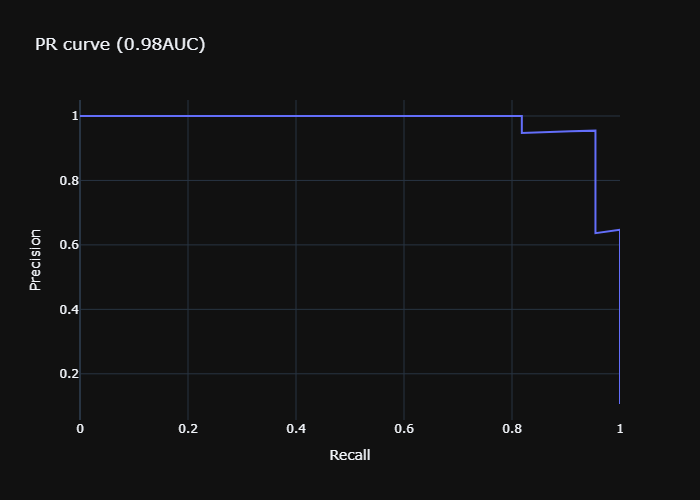

In [24]:
precision, recall, thresholds = precision_recall_curve(y_test, model.predict_proba(X_test_topics)[:, 1])
prauc = auc(recall, precision)

fig = go.Figure()
fig.add_trace(go.Scatter(x=recall, y=precision, mode="lines", name="PR curve", hovertext=thresholds, hovertemplate="<br>Precision: %{y}<br>Recall: %{x} <br>Threshold: %{hovertext:.2f}"))
fig.update_layout(title=f"PR curve ({prauc:.2f}AUC)", xaxis_title="Recall", yaxis_title="Precision", hovermode="x unified")
fig.show()

In this plot I try to see at which probability the model balances more the sensitivity to the positive class and the false positive rate. According to both the PR curve and the ECDF below, the model seems to be performing really well.

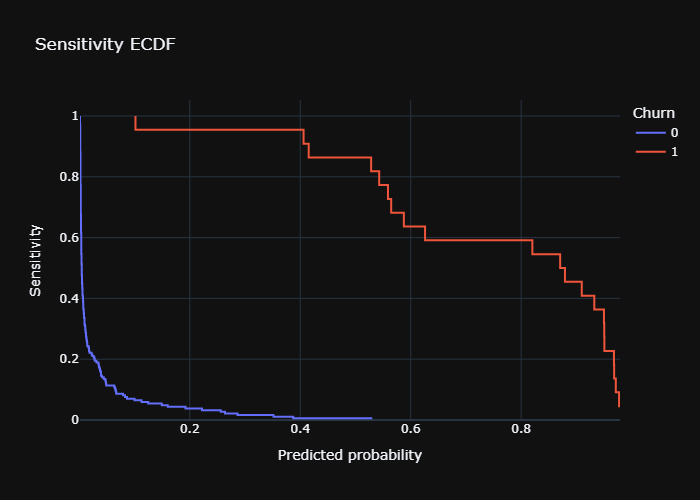

In [25]:
px.ecdf(x=model.predict_proba(X_test_topics)[:, 1], color=y_test, ecdfmode="reversed", title="Sensitivity ECDF", labels={"color": "Churn"}).update_layout(xaxis_title="Predicted probability", yaxis_title="Sensitivity", hovermode="x unified")

Below is some cause for concern. Variables that have really high importance may lead to biasing. Let us go to the shapley values so I can delve deeper into this concern.

In [26]:
feature_importance = model.get_feature_importance(prettified=True)
feature_importance

,Feature Id,Importances
0,total_trx,17.939687
1,risk,17.025562
2,days_trx,14.651951
3,region,10.064066
4,avg_trx_value,8.532677
5,is_male,6.408642
6,total_value,5.501343
7,most_frequent_establishment_type_ratio,5.381873
8,topic_1,3.671731
9,topic_3,2.491171


The total number of transactions is the most important variable for the model. Its impact it positive with a high magnitude for lower values. So, this model could flag new customers very easily.  However, this is expected from what we saw in the EDA. The number of transactions is a good indicator of churn. For a more generic model, it may be benefitial to remove this variable. Befor concluding this notebook I will execute the same experiment without them, for comparison.

Another point to observe is that our topic modeling seems to have worked. When present, the topics have a good impact on the model, with almost no impact in its absence.

c:\Users\kinte\miniconda3\envs\eleven\Lib\site-packages\shap\plots\colors\_colorconv.py:819: DeprecationWarning:

Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.

c:\Users\kinte\miniconda3\envs\eleven\Lib\site-packages\shap\plots\colors\_colorconv.py:819: DeprecationWarning:

Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.

c:\Users\kinte\miniconda3\envs\eleven\Lib\site-packages\shap\plots\colors\_colorconv.py:819: DeprecationWarning:

Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.

c:\Users\kinte\miniconda3\envs\eleven\Lib\site-packages\shap\plots\colors\_colorconv.py:819: DeprecationWarning:

Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.

c:\Users\kinte\minic

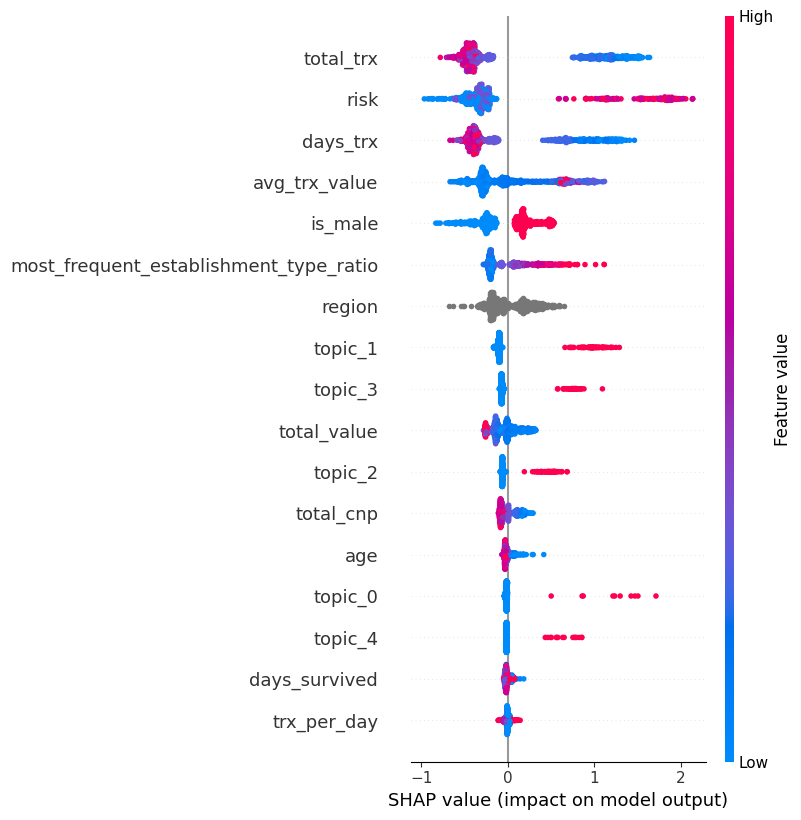

In [28]:
import shap
shap_values = shap.TreeExplainer(model).shap_values(X_train_topics)
shap.summary_plot(
    shap_values,
    X_train_topics,
)

To end this, I will run a CV to ensure that the model is not overfitting and is stable across different folds.

In [29]:
cv_data = cv(
    pool=Pool(X_train_topics, y_train, cat_features=categorial_features),
    params=model.get_params(),
    fold_count=5,
    plot=True,
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.9775993292
bestIteration = 258

Training on fold [1/5]

bestTest = 0.9605616714
bestIteration = 288

Training on fold [2/5]

bestTest = 0.9559724227
bestIteration = 228

Training on fold [3/5]

bestTest = 0.9440563945
bestIteration = 65

Training on fold [4/5]

bestTest = 0.9873085901
bestIteration = 47



The metrics are consistent across the folds. The model is performing well and is stable.

In [30]:
cv_data.tail(1)

,iterations,test-PRAUC-mean,test-PRAUC-std,train-PRAUC-mean,train-PRAUC-std,test-CrossEntropy-mean,test-CrossEntropy-std,train-CrossEntropy-mean,train-CrossEntropy-std
299,299,0.962622,0.019044,0.999062,0.000814,0.076292,0.02311,0.039763,0.003404


### Training without total_trx and days_trx

Let us look into a model without heavily skewed variables. I will remove some variables that are too related to churn and trx numbers. This way I can see if the model is still able to predict churn without these variables, which may make it more useful in a profile analisys scenario.

In [31]:
X_train_topics_without_trx = X_train_topics.drop(columns=["total_trx", "days_trx", "most_frequent_establishment_type_ratio"])
X_test_topics_without_trx = X_test_topics.drop(columns=["total_trx", "days_trx", "most_frequent_establishment_type_ratio"])

In [32]:
model_without_trx = CatBoostClassifier(
    iterations=300,
    learning_rate=0.01,
    depth=6,
    loss_function="CrossEntropy",
    cat_features=categorial_features,
    verbose=False,
    eval_metric="PRAUC",
    use_best_model=False,
)

model_without_trx.fit(
    X_train_topics_without_trx,
    y_train,
    eval_set=(X_test_topics_without_trx, y_test),
    plot=True,
)

y_pred_without_trx = model_without_trx.predict(X_test_topics_without_trx)

print(classification_report(y_test, y_pred_without_trx))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

              precision    recall  f1-score   support

           0       0.97      1.00      0.99       185
           1       1.00      0.77      0.87        22

    accuracy                           0.98       207
   macro avg       0.99      0.89      0.93       207
weighted avg       0.98      0.98      0.97       207



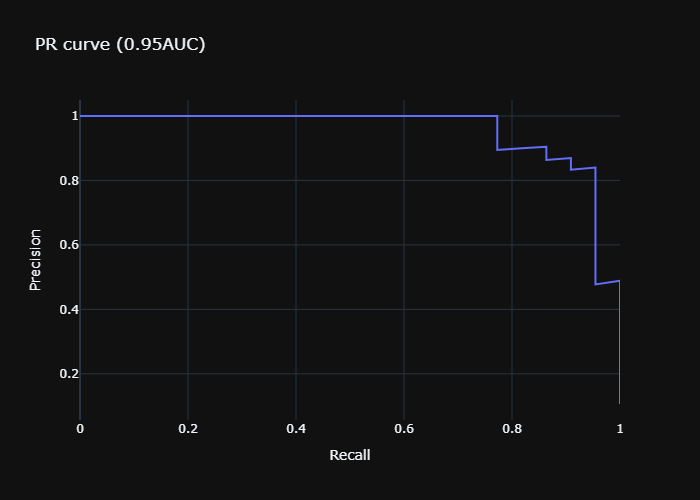

In [33]:
precision, recall, thresholds = precision_recall_curve(y_test, model_without_trx.predict_proba(X_test_topics_without_trx)[:, 1])
prauc = auc(recall, precision)

fig = go.Figure()
fig.add_trace(go.Scatter(x=recall, y=precision, mode="lines", name="PR curve", hovertext=thresholds, hovertemplate="<br>Precision: %{y}<br>Recall: %{x} <br>Threshold: %{hovertext:.2f}"))
fig.update_layout(title=f"PR curve ({prauc:.2f}AUC)", xaxis_title="Recall", yaxis_title="Precision", hovermode="x unified")
fig.show()

In [34]:
model_without_trx.get_feature_importance(prettified=True)

,Feature Id,Importances
0,risk,23.113716
1,region,17.013074
2,avg_trx_value,14.567822
3,total_value,11.399095
4,is_male,9.645334
5,total_cnp,9.368838
6,trx_per_day,3.306355
7,topic_1,3.192011
8,topic_2,1.926307
9,topic_3,1.748710


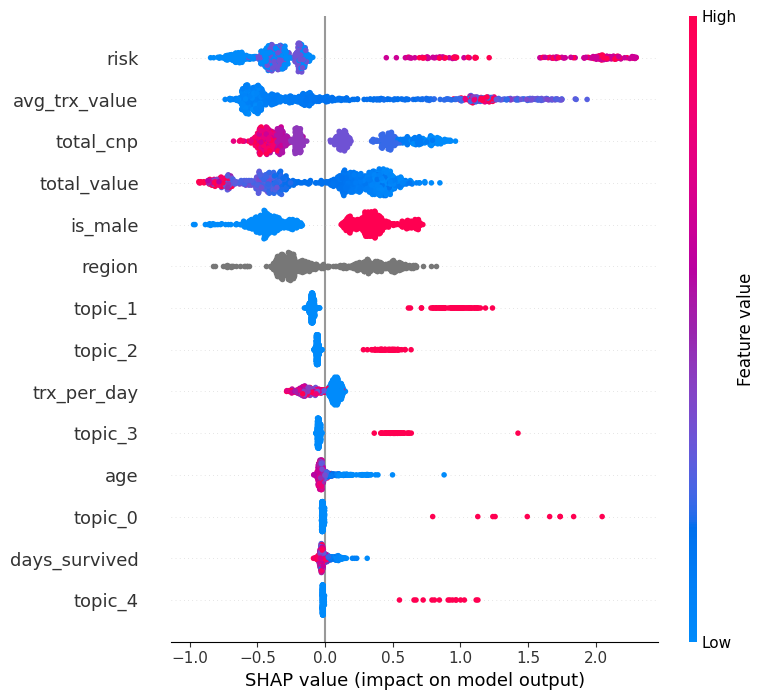

In [35]:
shap_values_without_trx = shap.TreeExplainer(model_without_trx).shap_values(X_train_topics_without_trx)
shap.summary_plot(
    shap_values_without_trx,
    X_train_topics_without_trx,
)

The performance is really comparable with minor loss of performance.

## Conclusion

This was a fairly simple case to deal with. The data wasn't unforgiving and had only a few inconsistencies. The model was able to predict churn with a stable performance accross folds and topic modeling was helpful for the model, as the shap plots showed us. 

Now, as requested, I will leave my suggestions:

- A bigger sample would be better to work with.

- Credit card limits would help to pin if the reason for churn was a low spending limit that wouldn't fulfill the associate needs. 

- The CC brand (VISA, MC, AMEX etc) and level (Gold, Plat etc) could also help differentiating customer profiles.

- Associate income also would be good for analyzing churn in relation to CC limit.

- Account balance over the last X would be nice to understand if the associate is using the account itself.

- Occupation data as it was, was not useful. I could have explored CBO tables to go up the hierarchy, but a more representative sample would be even better.

- Regarding transactional data, I would have liked to know if a transaction was flagged as fraud or not. This could be a good indicator of churn since some of the SAC messages were about stolen cards.

- Information about installments could be helpful as well.

- About the transcripts, a human labeled dataset would help avoid the topic modeling.

- The amount of transcripts were also too low.


To conclude, my considerations: the trained model was good, but I could test other simpler models to have a baseline. My understanding of the problem, from the data, is that the associates are looking for help, information and some responsibility of churn may be on the support side. I would start by looking at the support team and trying to understand where they could improve. Also, I would try to look at the product itself: is the credit card informations and rules of use clear enough? Are the associates being well informed about the product? Are the benefits clear and compelling to convince the associates to use the card? Campaigns to retain new associates could be a good idea.

To summarize, I suggest two fronts: better customer support and better benefits. 

To draw better conclusions, I would need more data. So this is all speculation.